# SOM projekat - Hepatitis C
### Pavle Padjin 2020/0061, Aleksa Djukic 2020/0161

## O bazi
Hepatitis C virus - Blood based Detection

5 klasa za klasifikaciju - Blood donor, Suspect Blood Donor, Hepatitis, Fibrosis, Cirrhosis

615 redova

Link: https://www.kaggle.com/datasets/amritpal333/hepatitis-c-virus-blood-biomarkers?select=hcvdat0.csv

## 1. Ucitavanje baze, osnovna obrada i prikaz

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
df = pd.read_csv('hcvdat0.csv')
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


### Suvisna kolona (fakticki indeks)

In [57]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
len(df)

615

### Proveravamo koliko nepostojecih podataka ima u svakoj od kolona

In [58]:
df.replace('?', np.nan, inplace=True)
df.replace('NA', np.nan, inplace=True)
df.replace('NAN', np.nan, inplace=True)
df.isna().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

### Menjamo nepostojece vrednosti sa ocekivanim vrednostima

S obzirom da su svi nepostojeci podaci u kolonama koje su numericke, menjamo ih sa ocekivanim vrednostima tih kolona respektivno

In [59]:
for col in df.columns:
    if df[col].isna().sum() > 0:
        df[col].fillna(df[col].mean(), inplace=True)

df.isna().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### Razlikujemo kategoricke i numericke kolone, kao i target kolonu (velicinu koju zelimo da predvidimo)

In [60]:
target_col = 'Category'
cat_columns = ['Sex', 'Category']
num_columns = list(df.columns.drop(cat_columns))

### Kodiranje kategorickih kolona:

In [61]:
for col in cat_columns:
    df[col] = pd.factorize(df[col])[0]

df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


### Provera da li kategoricke kolone imaju klase sa manje od 5% podataka

In [62]:
df['Sex'].value_counts()

0    377
1    238
Name: Sex, dtype: int64

### Kako je 'Sex' jedini kategoricki atribut i kako on nema manjinske klase, ne moramo da grupisemo manje klase u 'Ostalo'

## 2. Ispitivanje korelacije i kvaliteta karakteristika

### Pearson-ova korelacija
Metoda koja je koriscena je Pearson-ova korelacija. 

Ona ispituje u kojoj meri je prisutna linearna korelacija izmedju neka dva atributa. 

Uzima vrednosti iz [-1, 1], gde je 1 savrsena linearna korelacija, 0 nema linearnu korelaciju, a -1 je savrsena negativna linearna korelacija.

In [63]:
X = df.drop([target_col], axis=1)
y = df[target_col]
# check correlation
corr = X.corr()
corr.style.background_gradient(cmap='coolwarm')

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Age,1.000000,0.024544,-0.197005,0.168473,-0.006017,0.088666,0.032492,-0.075093,0.123978,-0.022296,0.153087,-0.153665
Sex,0.024544,1.000000,-0.146065,0.019547,-0.161785,-0.130891,-0.111177,-0.169111,0.029886,-0.159589,-0.133276,-0.051250
ALB,-0.197005,-0.146065,1.000000,-0.138858,0.001606,-0.193397,-0.221650,0.375848,0.204803,-0.001573,-0.155555,0.550033
ALP,0.168473,0.019547,-0.138858,1.000000,0.172461,0.062202,0.048600,0.032971,0.121914,0.149554,0.442262,-0.053633
ALT,-0.006017,-0.161785,0.001606,0.172461,1.000000,0.273325,-0.038468,0.146953,0.068023,-0.043025,0.248086,0.094373
AST,0.088666,-0.130891,-0.193397,0.062202,0.273325,1.000000,0.312231,-0.208536,-0.207507,-0.021387,0.491263,0.039888
BIL,0.032492,-0.111177,-0.221650,0.048600,-0.038468,0.312231,1.000000,-0.333172,-0.156261,0.031224,0.217024,-0.041309
CHE,-0.075093,-0.169111,0.375848,0.032971,0.146953,-0.208536,-0.333172,1.000000,0.420163,-0.011157,-0.110345,0.293184
CHOL,0.123978,0.029886,0.204803,0.121914,0.068023,-0.207507,-0.156261,0.420163,1.000000,-0.047667,-0.006828,0.206546
CREA,-0.022296,-0.159589,-0.001573,0.149554,-0.043025,-0.021387,0.031224,-0.011157,-0.047667,1.000000,0.121003,-0.031693


### Rezultati
Vidimo da su najvise medjusobno korelisane kolone **'PROT'** i **'ALB'**, **'GGT'** i **'ALP'**, **'GGT'** i **'AST'**, kao i **'CHOL'** i **'CHE'**.

To nam govori da je neke od navedenih atributa moguce izbaciti, jer su potencijalno redudantni.

### Information gain parametar

In [64]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi = pd.Series(mi, index=X.columns)

Sortiramo karakteristike od najvaznije ka najmanje vaznoj

In [65]:
mi = mi.sort_values(ascending=False)
mi

AST     0.232902
ALB     0.169243
ALP     0.155879
ALT     0.135658
BIL     0.127235
CHE     0.117832
GGT     0.108153
CREA    0.097212
PROT    0.079406
CHOL    0.057134
Age     0.034370
Sex     0.000000
dtype: float64

### Biranje 10 od 12 karakteristika

Potrebno je odbaciti dve karakteristike i za to cemo koristiti oba prethodna rezultata.

**Prvo,** vidimo da 'Sex' karakteristika ne donosi nikakvu informaciju o velicini koju predvidjamo, te mozemo bez razmisljanja da je odbacimo.

**Drugo,** vidimo da je 'CHOL' karakteristika treca od nazad po vaznosti, a takodje je solidno korelisana sa 'CHE' karakteristikom (koja donosi znacajno veci information gain). Stoga, odbacujemo i 'CHOL' karakteristiku.


In [66]:
X = X.drop(['Sex', 'CHOL'], axis=1)

## 3. Redukcija dimenzionalnosti - LDA i PCA

In [67]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda2 = LDA(n_components=2)
X_lda2 = lda2.fit_transform(X, y)


### LDA redukcija na 2 dimenzije

Text(0.5, 1.0, 'LDA raspodela po klasama sa 2 komponente')

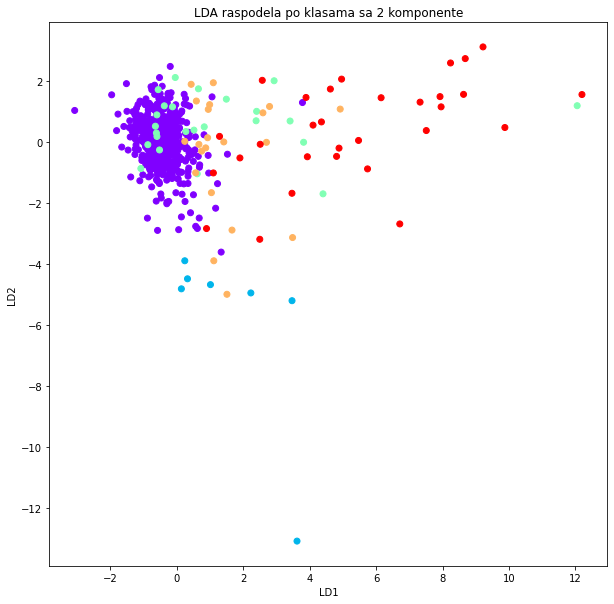

In [68]:
plt.figure(figsize=(10, 10))
plt.scatter(X_lda2[:, 0], X_lda2[:, 1], c=y, cmap='rainbow')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.title('LDA raspodela po klasama sa 2 komponente')

### Diskusija
Stice se utisak da dve LDA dimenzije nisu dovoljno informativne, jer se ne vidi jasna granica izmedju klasa (iako postoji odredjena separabilnost).

### LDA redukcija na 3 dimenzije

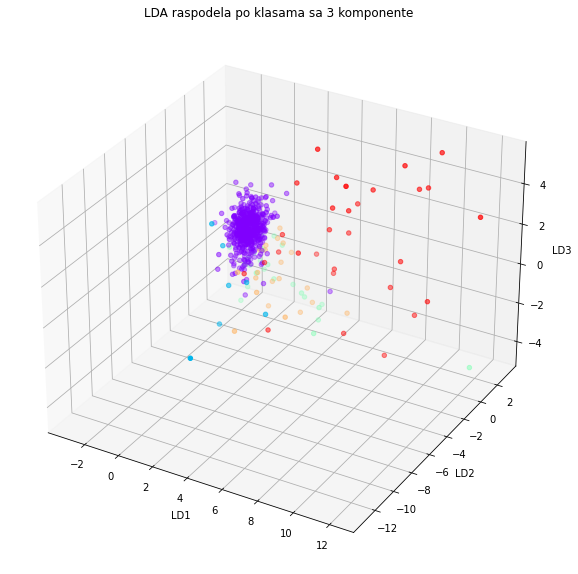

In [69]:
lda3 = LDA(n_components=3)
X_lda3 = lda3.fit_transform(X, y)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_lda3[:, 0], X_lda3[:, 1], X_lda3[:, 2], c=y, cmap='rainbow')
ax.set_xlabel('LD1')
ax.set_ylabel('LD2')
ax.set_zlabel('LD3')
plt.title('LDA raspodela po klasama sa 3 komponente')
plt.show()

### Diskusija

Koriscenje 3 dimenzije pruza dosta vidljiviju granicu izmedju klasa.

S obzirom da imamo vise od dve klase, poredicemo 2 dimenzije LDA sa 2 dimenzije PCA.

### PCA redukcija na 2 dimenzije

Text(0.5, 1.0, 'PCA raspodela po klasama sa 2 komponente')

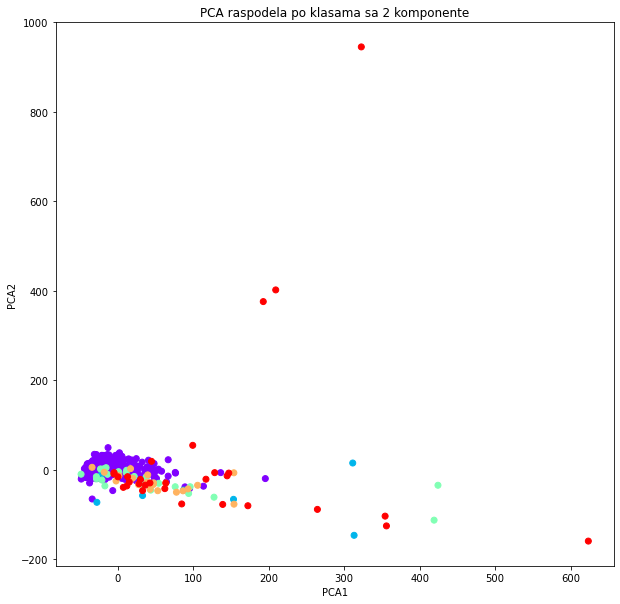

In [70]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='rainbow')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA raspodela po klasama sa 2 komponente')

### Diskusija

Stice se utisak da je LDA sa 2 dimenzije uradio bolji posao u razdvajanju klasa od PCA sa 2 dimenzije (Sto i ima smisla s obzirom na ciljeve koje treba da ostvari svaka od metoda)

Stoga, nastavljamo sa **LDA redukcijom na 3 dimenzije**.

In [71]:
X_red = X_lda3

Text(0.5, 0, 'LDA3')

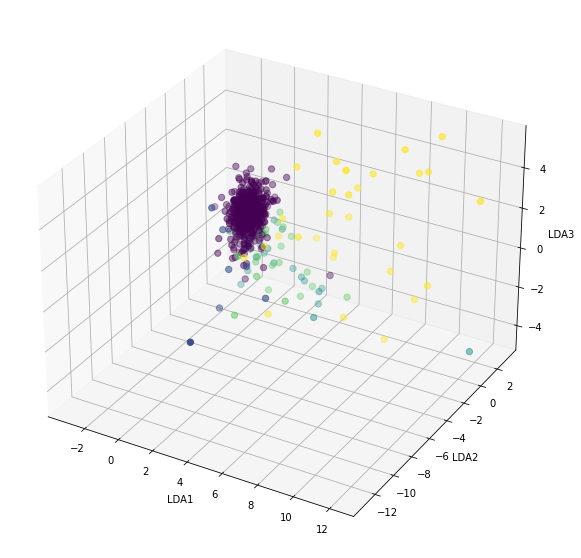

In [72]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_lda3[:, 0], X_lda3[:, 1], X_lda3[:, 2], c=y , s=40)
ax.set_xlabel('LDA1')
ax.set_ylabel('LDA2')
ax.set_zlabel('LDA3')


## 4. Test vise hipoteza - Bajesov klasifikator

Posto imamo vise od 2 klase, koristicemo Bajesov klasifikator za testiranje hipoteza.

Pretpostavicemo da je uslovna raspodela podataka (pri uslovu svake od klasa) normalna raspodela (sto je razumna pretpostavka, ako pogledamo grafike iznad). 


### Za apriorne verovatnoce uzecemo broj procenat instanci svake od klasa

In [73]:
prior_p = np.array([
    len(y[y == i]) / len(y) for i in range(5)
])

In [74]:
X_0 = X_red[y == 0]
mean = np.mean(X_0, axis = 0)
cov = np.cov(X_0.T)

from scipy.stats import multivariate_normal

pdf_0 = multivariate_normal.pdf(X_red, mean=mean, cov=cov)

### Delimo podatke na one za trening i za test

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_red, y, test_size=0.2, random_state=42)

### Rad sa trening podacima

In [76]:
X_means = np.zeros((5, X_train.shape[1]))
X_cov = np.zeros((5, X_train.shape[1], X_train.shape[1]))
for k in range(5):
    X_means[k] = np.mean(X_train[y_train == k], axis=0)
    X_cov[k] = np.cov(X_train[y_train == k].T)

y_train_pred = np.zeros(len(y_train))

for i in range(len(y_train)):
    pdf = np.zeros(5)
    for k in range(5):
        pdf[k] = multivariate_normal.pdf(X_train[i], mean=X_means[k], cov=X_cov[k]) * prior_p[k]
    y_train_pred[i] = np.argmax(pdf)


print(f'Tacnost nad trening podacima: {len(y_train[y_train == y_train_pred]) / len(y_train)}')

Tacnost nad trening podacima: 0.943089430894309


### Evaluacija nad test podacima

In [77]:
y_test_pred = np.zeros(len(y_test))
for i in range(len(y_test)):
    pdf = np.zeros(5)
    for k in range(5):
        pdf[k] = multivariate_normal.pdf(X_test[i], mean=X_means[k], cov=X_cov[k]) * prior_p[k]
    y_test_pred[i] = np.argmax(pdf)

print(f'Tacnost nad test podacima: {len(y_test[y_test == y_test_pred]) / len(y_test)}')

Tacnost nad test podacima: 0.8455284552845529


Dobijena tacnost na treningu i testu  je zadovoljavajuca, ali treba uzeti u obzir da tacnost nije najbolja metrika za ovaj problem, jer imamo **nebalansiran skup podataka**. 

Hajde da pogledamo kako izgledaju matrice konfuzije

<AxesSubplot:>

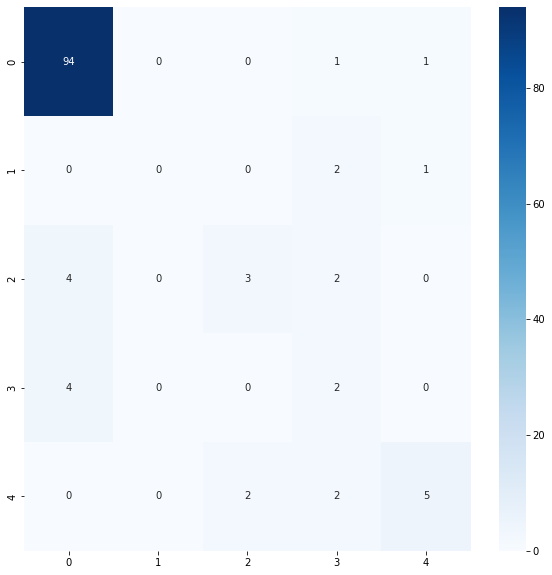

In [78]:
# visualize confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


### Diskusija
Mozemo videti da dolazi do problema sa klasom sa indeksom 1, jer nismo nijednom dali predikciju da instanca pripada toj klasi (recall 0).

Ovo bi potencijalno moglo da se resi tehnikama ponovnog uzorkovanja (npr. SMOTE resampling)

Pored ovoga, nas klasifikator radi dobro

## 5. Neparametarska klasifikacija i metoda krosvalidacije

Ideja metode krosvalidacije je da eliminisemo nasumicni faktor kada ispitujemo tacnost klasifikatora (ili neku drugu metriku).
To radimo tako sto vise puta (k puta) podelimo skup podataka na trening i test podatke, i onda izracunamo srednju vrednost metrike koju ispitujemo.

Glavna metrika bila bi **f1 score** (zbog nebalansiranosti skupa podataka), ali zbog projektnog zahteva ce i **tacnost** biti uzeta u obzir

Kao metod neparametarske klasifikacije koristice se **KNN**

Text(0.5, 1.0, 'Tacnost u zavisnosti od broja suseda')

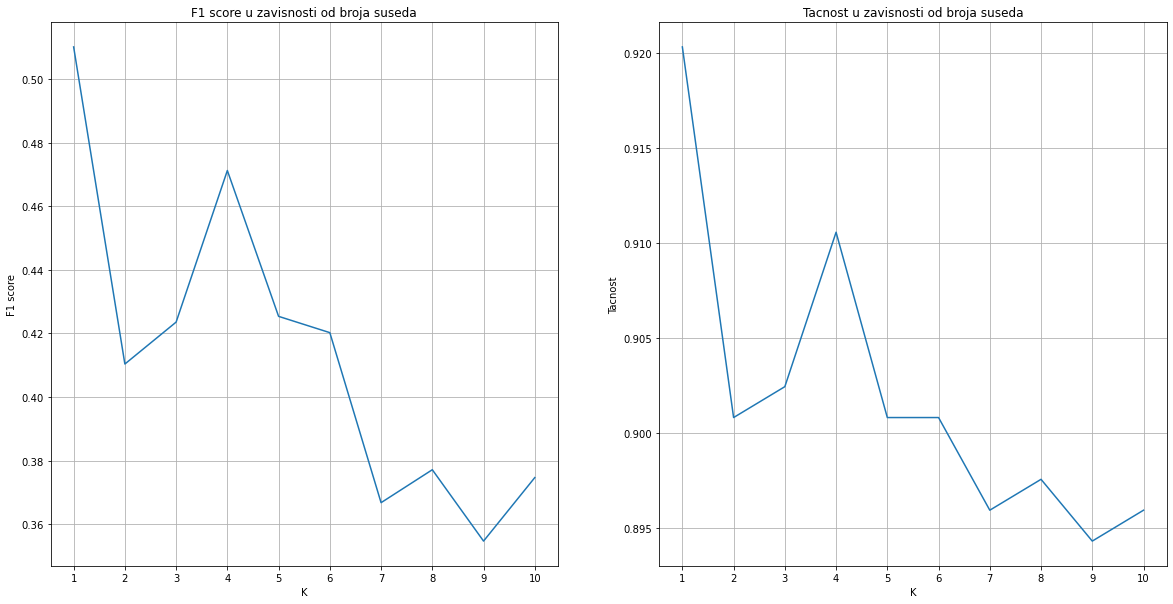

In [79]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

n_folds = 5
KMAX = 10
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=27)

f1_metrics = np.zeros(KMAX)
acc_metrics = np.zeros(KMAX)


X = np.array(X)

for k in range(1, KMAX + 1):
    # defisemo knn objekat za ovaj broj suseda
    knn = KNeighborsClassifier(n_neighbors=k)
    for train_idx, test_idx in skf.split(X_red, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        knn.fit(X_train, y_train)
        y_test_pred = knn.predict(X_test)
        f1_metrics[k - 1] += f1_score(y_test, y_test_pred, average='macro')
        acc_metrics[k - 1] += knn.score(X_test, y_test)

    f1_metrics[k - 1] /= n_folds
    acc_metrics[k - 1] /= n_folds

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(range(1, KMAX + 1), f1_metrics)
ax[0].set_xlabel('K')
ax[0].set_ylabel('F1 score')
ax[0].set_xticks(range(1, KMAX + 1))
ax[0].grid()
ax[0].set_title('F1 score u zavisnosti od broja suseda')

ax[1].plot(range(1, KMAX + 1), acc_metrics)
ax[1].set_xlabel('K')
ax[1].set_ylabel('Tacnost')
ax[1].set_xticks(range(1, KMAX + 1))
ax[1].grid()
ax[1].set_title('Tacnost u zavisnosti od broja suseda')

### Diskusija
Vidimo da dobijamo prilicno dobre rezultate i u vidu tacnosti i u vidu f1 score-a ako izaberemo **k = 4**, tako da to uzimamo kao optimalan broj suseda

**Napomena:**

Koriscen je StratifiedKFold s obzirom da imamo nebalansirane podatke, s ciljem da fiksiramo procenat odbiraka svake od klasa koji ce se naci u test skupu (ovim otklanjamo veliki deo nasumicnosti pri podeli na trening i test skup, a samim tim i povecavamo legitimnost rezultata)

### Matrica konfuzije za optimalan broj suseda (k = 4)

<AxesSubplot:>

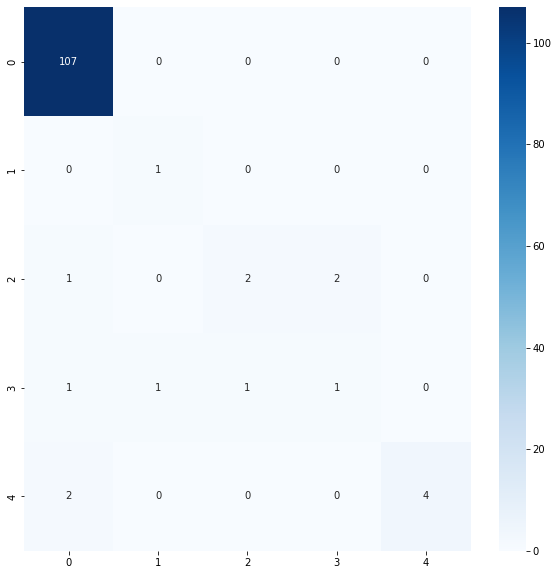

In [80]:
n_folds = 5 #koristimo crossval klasu da bismo opet dobili balansirane trening i test skupove
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=27)

k = 4
knn = KNeighborsClassifier(n_neighbors=k)
for train_idx, test_idx in skf.split(X_red, y):
    X_train, X_test = X_red[train_idx], X_red[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    knn.fit(X_train, y_train)
    y_test_pred = knn.predict(X_test)
    break

cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


### Diskusija

Vidimo da sada uspevamo da pogodimo instancu klase 1 (od koje imamo najmanje primeraka u trening skupu)

## 6. Neuralne mreze

Koristice se PyTorch modul za implementaciju neuralnih mreza.

Bice redom testirane sledece arhitekture:
1. Arhitektura sa jednim skrivenim slojem, redom sa premalo, previse i adekvatnim brojem neurona
2. Arhitektura sa dva ili vise skrivena sloja
3. Primena ranog zaustavljanja na najbolju arhitekturu iz prethodnih koraka
4. Primena regularizacije u vidu dropout-a na najbolju arhitekturu iz prethodnih koraka

### Mreza sa jednim skrivenim slojem

In [208]:
import torch
from torch import nn

# jedan skriveni sloj
class MLP1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU() # relu aktivaciona funkcija
        self.fc2 = nn.Linear(hidden_size, output_size)
        # softmax funkcija (koristi se kod klasifikacije sa vise od 2 klase)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        out = self.softmax(x)
        return out

In [209]:
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=27)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    break

from torch.utils.data import DataLoader, TensorDataset

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


# podaci se skaliraju
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train, X_test = torch.tensor(X_train, dtype=torch.float), torch.tensor(X_test, dtype=torch.float)
y_train, y_test = torch.tensor(y_train, dtype=torch.long), torch.tensor(y_test, dtype=torch.long)

#### Model sa premalo neurona u skrivenom sloju

In [268]:
def train_model(model, n_epochs = 30, lam = 0.0):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), shuffle=True)

    val_acc = []

    for epoch in range(n_epochs):
        print(f'Epoch: {epoch + 1}')
        training_loss = 0.0
        # treniranje
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(inputs)
            loss_val = loss(output, labels)
            loss_val.backward()
            optimizer.step()

            training_loss += loss_val.item()
        training_loss /= len(X_train)
        print(f'Epoch: {epoch + 1},training loss: {training_loss}')

        # evaluacija
        acc = 0.0
        val_loss = 0.0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                output = model(inputs)
                _, predicted = torch.max(output.data, 1)
                acc += (predicted == labels).sum().item()
                val_loss += loss(output, labels).item()
                
            val_loss /= len(X_test)
            acc /= len(X_test)
            val_acc.append(acc)
            print(f'Epoch: {epoch + 1}, val loss: {val_loss} val acc: {acc}')
    return val_acc

In [ ]:
model1_low = MLP1(10, 1, 5)
val_acc = train_model(model1_low, 200)

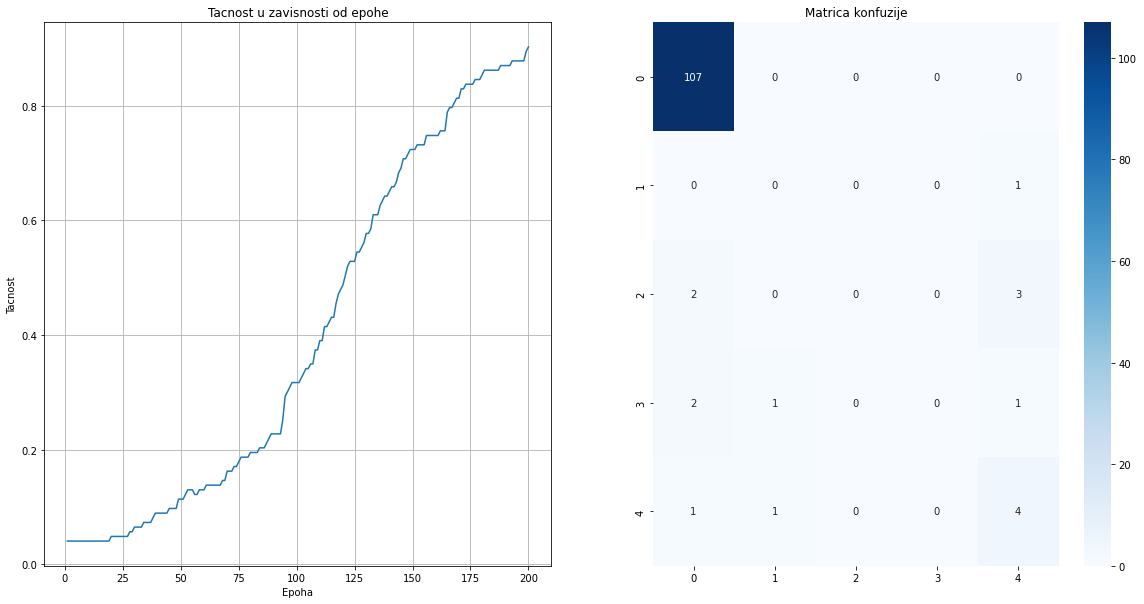

In [218]:
def plot_results(model, X_test, y_test, val_acc):
    # Grafik tacnosti kroz vreme
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].plot(range(1, len(val_acc)+1), val_acc)
    ax[0].set_xlabel('Epoha')
    ax[0].set_ylabel('Tacnost')
    ax[0].grid()
    ax[0].set_title('Tacnost u zavisnosti od epohe')
    # matrica konfuzije
    y_test_pred = model(X_test)
    _, predicted = torch.max(y_test_pred.data, 1)
    cm = confusion_matrix(y_test, predicted)
    ax[1].set_title('Matrica konfuzije')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1])
plot_results(model1_low, X_test, y_test, val_acc)

### Diskusija

Vidimo da dolazi do toga da pogadja instance prve i pete klase, dok ostale klase nikada ne pogadja. 

Iako dobijamo dobar rezultat u vidu tacnosti, to na ovom problemu nije reprezentativno. Pretpostavka je da mozda nije dovoljno kompleksna mreza da modeluje sablone koji se javljaju u instancama ostalih klasa

#### Model sa previse neurona u skrivenom sloju

In [ ]:
# previse neurona u skrivenom sloju

model1_high = MLP1(10, 10000, 5)
val_acc = train_model(model1_high, 50)

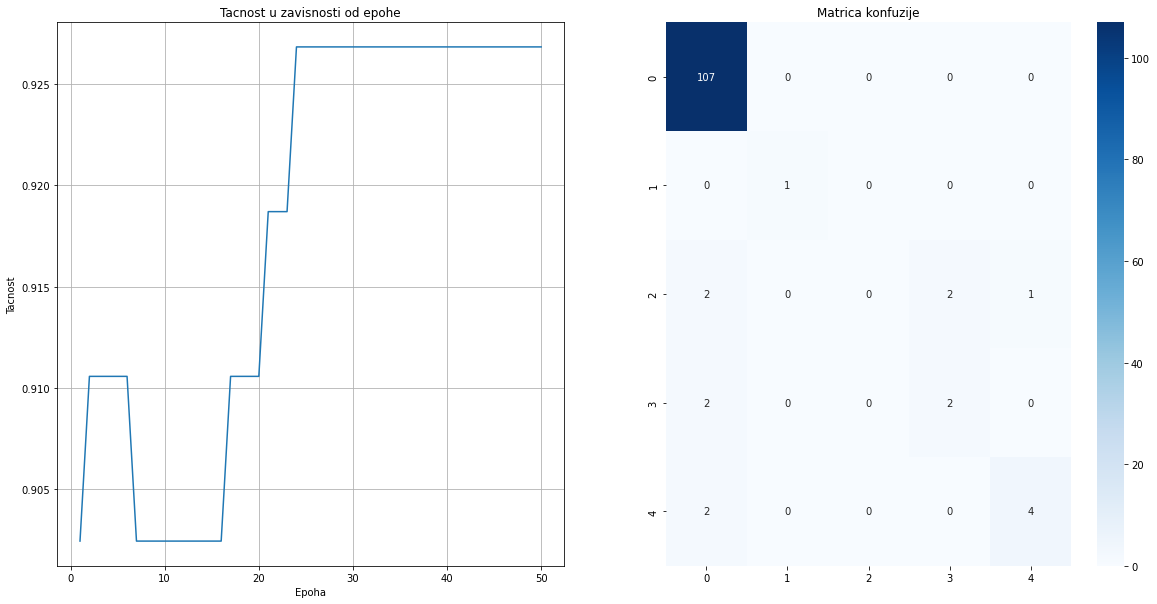

In [220]:
plot_results(model1_high, X_test, y_test, val_acc)

### Diskusija
Ovaj model je solidno bolji od prethodnog u vidu pogadjanja instanci razlicitih klasa, ali je cinjenica da ima ogroman broj neurona, sto smanjuje brzinu treninga i inferencije, a i povecava mogucnost overfitting-a (tesko je reci da li je do toga doslo ovde, ali u svakom slucaju se mreza pokazala dobro)

In [ ]:
# model sa optimalnim brojem neurona u skrivenom sloju

model1_optimal = MLP1(10, 600, 5)
val_acc = train_model(model1_optimal, 20)

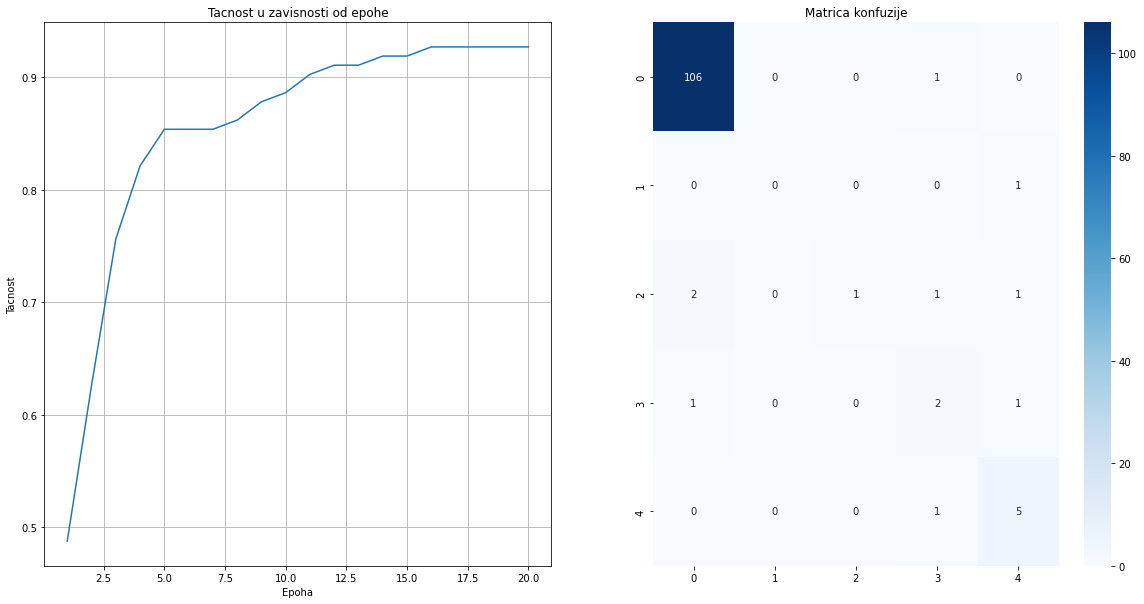

In [233]:
plot_results(model1_optimal, X_test, y_test, val_acc)

### Diskusija

Ni ovaj model nije idealan u pogadjanju manjinskih klasa, ali zato koristi red velicine manje neurona od modela sa previse neurona. Moze se reci da je ovaj model isti, ako ne i bolji od modela sa previse neurona. Dakle, ovo je najbolji model

#### Model sa dva skrivena sloja

In [234]:
class MLP2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.relu(self.linear1(x))
        out = self.relu(self.linear2(out))
        out = self.softmax(self.linear3(out))
        return out
    

In [ ]:
# model sa dva skrivena sloja
model2 = MLP2(10, 100, 5)

val_acc = train_model(model2)

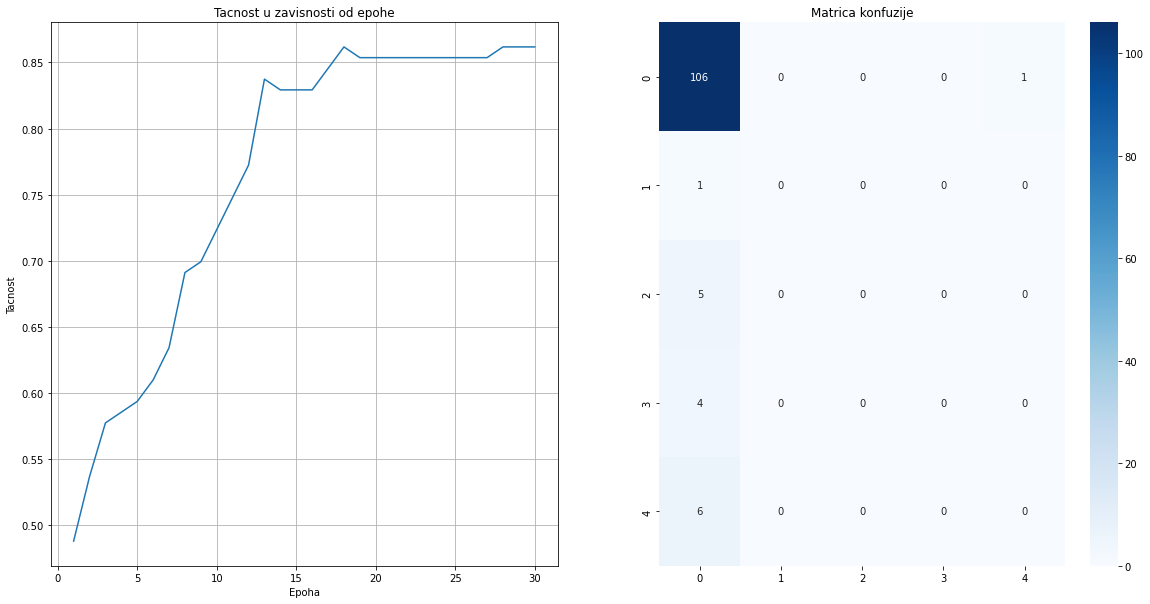

In [237]:
plot_results(model2, X_test, y_test, val_acc)

### Diskusija
Vidimo da je model sa 2 skrivena sloja lakse overfitovati, te je ovo najgori od odabrana 3 modela. Prosto priroda naseg problema ne zahteva toliku kompleksnost modela. Vidimo da je toliko lako overfitovao da prakticno predvidja samo instance vecinske klase (to nije pametan klasifikator)

#### Early stopping

Ideja early stopping metode jeste da se zaustavi treniranje mreze kada se vidi da opadaju performanse

In [242]:
def train_early_stopping(model, patience = 20):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=True)

    val_acc = []
    best_f1 = 0.0
    best_model = None
    for epoch in range(30):
        print(f'Epoch: {epoch + 1}')
        training_loss = 0.0
        # treniranje
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(inputs)
            loss_val = loss(output, labels)
            loss_val.backward()
            optimizer.step()

            training_loss += loss_val.item()
        training_loss /= len(X_train)
        print(f'Epoch: {epoch + 1},training loss: {training_loss}')

        # evaluacija
        acc = 0.0
        val_loss = 0.0
        f1 = 0.0

        with torch.no_grad():
            for i, (inputs, labels) in enumerate(test_loader):
                output = model(inputs)
                _, predicted = torch.max(output.data, 1)
                acc += (predicted == labels).sum().item()
                val_loss += loss(output, labels).item()
                f1 += f1_score(labels, predicted, average='macro')
                
            val_loss /= len(X_test)
            acc /= len(X_test)
            f1 /= len(X_test)

            val_acc.append(acc)
            print(f'Epoch: {epoch + 1}, val loss: {val_loss} val acc: {acc}')
            if f1 > best_f1:
                best_f1 = f1
                best_model = model
                patience = 5
            else:
                patience -= 1
            if patience == 0:
                break
    return val_acc, best_model

In [ ]:
model1_optimal = MLP1(10, 600, 5)
val_acc, best_model = train_early_stopping(model1_optimal)

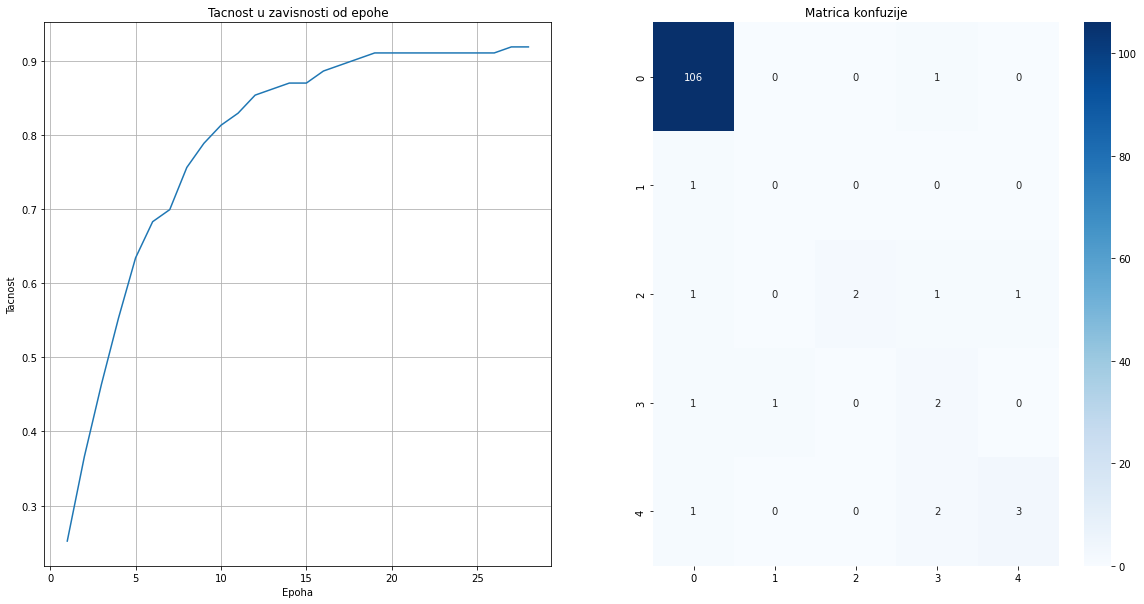

In [244]:
plot_results(best_model, X_test, y_test, val_acc)

### Diskusija
Koristili smo f1 score kao metriku za early stopping, jer je to najbolja metrika za nas problem. Vidimo da je mreza zaustavljena posle 30 epoha. Odradili smo dosta manje epoha nego pre, a dobili smo za sada najbolji model (najveci f1 score)

#### Regularizacija

Regularizacija je svaki vid dodatnog ogranicenja koje se postavlja na model, sa ciljem da smanji overfitovanje modela
nad datim podacima, odnosno da sama funkcija koju model aproksimira bude sto jednostavnija.

Mi cemo koristiti regularizaciju u vidu dodavanja clana loss funkciji. Taj clan je suma kvadrata tezina svih neurona u mrezi, pomnozena sa nekim koeficijentom lambda. Ima za cilj da smanji vrednosti tezina, i samim tim da smanji kompleksnost modela (da budu vise glatke funkcije)

In [ ]:
model_reg = MLP1(10, 600, 5)
val_acc = train_model(model_reg, n_epochs = 20, lam = 2e-4)

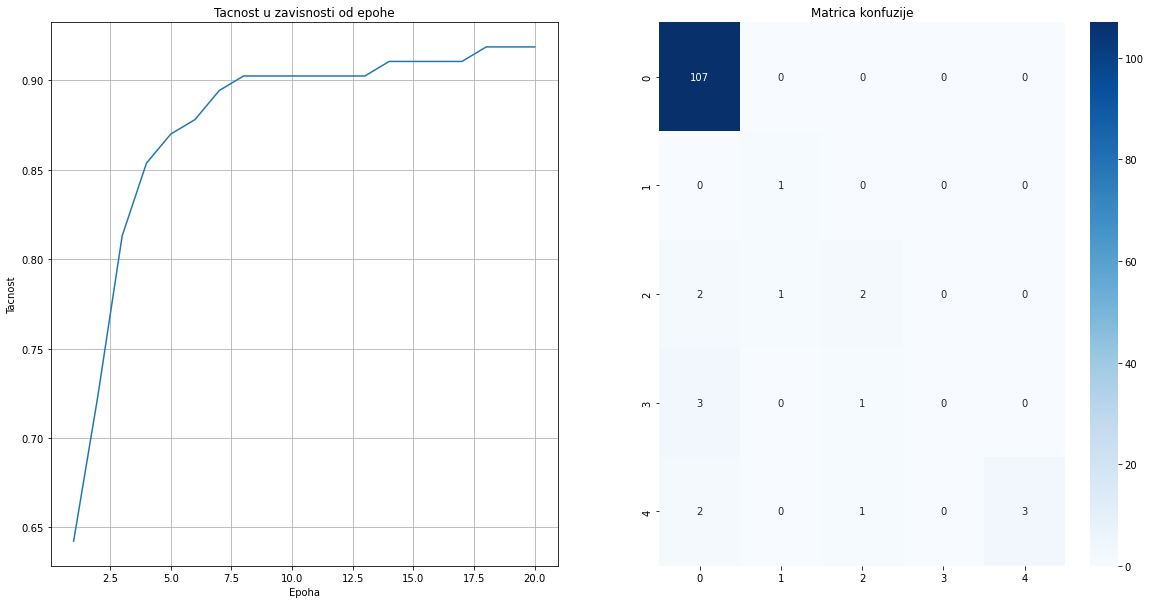

In [282]:
plot_results(model_reg, X_test, y_test, val_acc)

### Diskusija
Vidimo da mreza sa regularizacijom daje okej rezultate, ali nije bolja od mreze koja koristi early stopping.

## Hvala na paznji!